In [113]:
# --- Project Setup ---
from setup_notebook import setup_project_root
setup_project_root()

# --- Imports ---
from src.project_config import RAW_DIR, IMAGES_DIR, COLORS_MODELS, PROCESSED_DIR, PROTEIN_IDS_CSV, get_paths_protein, get_paths
from src.statistics.clustering_algorithm import identify_clusters
from src.statistics.statistics_per_2D import compute_2D_statistics
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 1. Cluster regions of difference between the VEPs

In [4]:
def flatten_clusters(cluster_dict):
    rows = []
    for protein_id, clusters in cluster_dict.items():
        for cluster in clusters:
            rows.append({
                "UniProtID": protein_id,
                "range": cluster["range"],
                "avg_diff": cluster["avg_diff"],
                "more pathogenic": cluster["more pathogenic"]
            })
    return pd.DataFrame(rows)

In [ ]:
# Compute for all human proteins the difference clusters 
protein_ids = pd.read_csv(PROTEIN_IDS_CSV) # all human proteins
SEARCH_WINDOW_SIZE = 9
THRESHOLD = 0.2

for protein in tqdm(protein_ids["Protein_ID"], desc="Processing proteins"):
    try:
        paths = get_paths_protein(protein)
        matrix_diff = pd.read_csv(paths["difference_path"], index_col=0)
    except FileNotFoundError:
        print(f"{protein} not found.")
        continue
    
    cluster_dict = identify_clusters(protein, matrix_diff, threshold=THRESHOLD, search_window_size=SEARCH_WINDOW_SIZE)
    
    # Flatten and save
    clusters_df = flatten_clusters(cluster_dict)
    clusters_df.to_csv(get_paths()["clusters_path"] / f"{protein}_clusters.csv", index=False)

### 2. Compute Average pathogenicity rank Scores per Protein

In [6]:
protein_ids = pd.read_csv(PROTEIN_IDS_CSV) # all human proteins
save_path = PROCESSED_DIR / "6.4.Rankscore_per_structure"
count_error = 0

for protein in tqdm(protein_ids["Protein_ID"], desc="Computing 2D statistics"):
    try:
        result_2D = compute_2D_statistics(protein, feature = "2D")
        result_topology = compute_2D_statistics(protein, feature = "Topology")
    except Exception as e:
        print(f"Error processing {protein}: {e}")
        count_error += 1
        print(f"Total errors so far: {count_error}")
        continue
    # Save results to CSV
    result_2D.to_csv(save_path / "2D_Rankscores" / f"{protein}_2D_statistics.csv", index=False)
    result_topology.to_csv(save_path / "Topology_Rankscores" / f"{protein}_Topology_statistics.csv", index=False)

Computing 2D statistics:   0%|          | 0/20246 [00:00<?, ?it/s]

Error processing Q8N841: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q8N841_statistics.csv'
Total errors so far: 1
Error processing Q9BRI3: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q9BRI3_statistics.csv'
Total errors so far: 2
Error processing Q07654: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q07654_statistics.csv'
Total errors so far: 3
Error processing Q9NS71: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q9NS71_statistics.csv'
Total errors so far: 4
Error processing Q9NVI7: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/

/Users/doma/Documents/Bachelor_Arbeit/Code/src/statistics/statistics_per_2D.py:42: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_statistics = pd.read_csv(get_paths_protein(protein_id)["dssp_protein_path"], index_col=0)
/Users/doma/Documents/Bachelor_Arbeit/Code/src/statistics/statistics_per_2D.py:42: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_statistics = pd.read_csv(get_paths_protein(protein_id)["dssp_protein_path"], index_col=0)


Error processing P01876: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/P01876_statistics.csv'
Total errors so far: 68
Error processing Q14160: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q14160_statistics.csv'
Total errors so far: 69
Error processing Q96RK0: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q96RK0_statistics.csv'
Total errors so far: 70
Error processing Q6ZQW0: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q6ZQW0_statistics.csv'
Total errors so far: 71
Error processing A6NC62: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statist

In [13]:
# Define What Proteome you want the overall statistics for and for what structures
PROTEOME = "human"
METHOD = "2D"
protein_id = "P05067"  # Example protein ID, replace with actual ID as needed

proteomes = {"human": [pd.read_csv(PROTEIN_IDS_CSV), "Protein_ID"],
             "n_out": [pd.read_csv(PROCESSED_DIR / "Human_N_Out_Proteome.csv", usecols=["entry"]), "entry"],
             "multispan": [pd.read_csv(PROCESSED_DIR / "Multispan_proteome_cleaned.csv"), "Entry"]
             }

methodes = {"2D": PROCESSED_DIR / "6.4.Rankscore_per_structure" / "2D_Rankscores", 
            "Topology": PROCESSED_DIR / "6.4.Rankscore_per_structure" / "Topology_Rankscores"}


print(methodes[METHOD] / f"{protein_id}_{"2D" if METHOD == "2D" else "Topology"}_statistics.csv")
df = pd.read_csv(methodes[METHOD] / f"{protein_id}_{"2D" if METHOD == "2D" else "Topology"}_statistics.csv")

df.head(10)

/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/6.4.Rankscore_per_structure/2D_Rankscores/P05067_2D_statistics.csv


,2D_Structures,AM_mean,AM_std,ESM_mean,ESM_std,count,Structure
0,B,0.578633,0.350058,0.768100,0.141411,3,Beta bridge
1,I,0.636160,0.232947,0.648600,0.239495,5,Helix-5
2,G,0.571862,0.189795,0.459062,0.293435,8,Helix-3
3,P,0.543093,0.232477,0.461147,0.281900,15,κ‐helix
4,S,0.559335,0.213399,0.570035,0.255500,31,Bend
5,T,0.518563,0.223610,0.556042,0.263371,52,Turn
6,E,0.698908,0.214498,0.743724,0.166799,74,Strand
7,H,0.712670,0.183426,0.709000,0.176451,273,Alpha helix
8,-,0.448992,0.237771,0.443360,0.254829,309,Disorded


### 3. Compute Overall Average pathogenicity Rank scores per 2D Structure

In [28]:
# Compute the overall statistics for structures
# Define What Proteome you want the overall statistics for and for what structures
PROTEOME = "human"
METHOD = "Topology"

proteomes = {"human": [pd.read_csv(PROTEIN_IDS_CSV), "Protein_ID"],
             "n_out": [pd.read_csv(PROCESSED_DIR / "Human_N_Out_Proteome.csv", usecols=["entry"]), "entry"],
             "multispan": [pd.read_csv(PROCESSED_DIR / "Multispan_proteome_cleaned.csv"), "Entry"]
             }

methodes = {"2D": PROCESSED_DIR / "6.4.Rankscore_per_structure" / "2D_Rankscores", 
            "Topology": PROCESSED_DIR / "6.4.Rankscore_per_structure" / "Topology_Rankscores"}



def compute_pooled_std(mean_total, components):
    # Filter out components with missing std or zero count
    valid_components = [
        (mean, std, count)
        for mean, std, count in components
        if pd.notnull(std) and count > 0
    ]

    if not valid_components:
        return None  # Or float('nan') if preferred

    total_n = sum(c for _, _, c in valid_components)
    pooled_var = sum(
        c * (std**2 + (mean - mean_total)**2)
        for mean, std, c in valid_components
    ) / total_n

    return np.sqrt(pooled_var)



def map_topology_to_category(topology_label):
    """
    Map specific topological domains to broader categories.
    """
    label = topology_label

    if any(term in label for term in ["Extracellular", "Lumenal", "Lumenal, vesicle", "melanosome", "Exoplasmic loop", "Extracellular,Lumenal"]):
        return "Extracellular"
    elif any(term in label for term in ["Cytoplasmic", "Nuclear", "Mitochondrial matrix", "Peroxisomal", 
                                        "Peroxisomal matrix", "Vacuolar", "Mother cell cytoplasmic", "Vesicular", "Intragranular"]):
        return "Cytoplasmic"
    elif any(term in label for term in ["Transmembrane", "Perinuclear space", "Mitochondrial intermembrane"]):
        return "Transmembrane"
    else:
        # Optional: categorize unknowns, or skip
        return None  # or return "Other"






count_errors = 0

# Structures: each will hold total weighted AM/ESM and total count
aggregated_data = defaultdict(lambda: {
    'AM_sum': 0.0, 'ESM_sum': 0.0,
    'AM_std_components': [], 'ESM_std_components': [],
    'count': 0
})

# Loop through all CSV files in the directory
for protein_id in tqdm(proteomes[PROTEOME][0][proteomes[PROTEOME][1]], desc="Processing Proteins"):
    try:
        df = pd.read_csv(methodes[METHOD] / f"{protein_id}_{"2D" if METHOD == "2D" else "Topology"}_statistics.csv")
    except FileNotFoundError:
        count_errors += 1
        print(f"File not found for {protein_id}, skipping. {count_errors}")

    
    for _, row in df.iterrows():        # _ row index, row = row data itself
        original_key = row['Structure' if METHOD == "2D" else 'Topological domain']
        key = original_key if METHOD == "2D" else map_topology_to_category(original_key)
        if key is None:
            continue  # Skip unmapped labels

        count = int(row['count'])
        am_mean = float(row['AM_mean'])
        am_std = float(row['AM_std'])
        esm_mean = float(row['ESM_mean'])
        esm_std = float(row['ESM_std'])
        
        # Update sums for weighted mean
        aggregated_data[key]['AM_sum'] += am_mean * count
        aggregated_data[key]['ESM_sum'] += esm_mean * count
        aggregated_data[key]['count'] += count

        # Store components for pooled variance calculation later
        aggregated_data[key]['AM_std_components'].append((am_mean, am_std, count))
        aggregated_data[key]['ESM_std_components'].append((esm_mean, esm_std, count))



# Calculate total count for percentage calculation
total_count = sum(data['count'] for data in aggregated_data.values())   

# Prepare final result
final_rows = []
for key, data in aggregated_data.items():
    count = data['count']
    am_mean = data['AM_sum'] / count
    esm_mean = data['ESM_sum'] / count
    percentage = (count / total_count) * 100

    am_std_pooled = compute_pooled_std(am_mean, data['AM_std_components'])
    esm_std_pooled = compute_pooled_std(esm_mean, data['ESM_std_components'])

    final_rows.append({
        'Structure': key,
        'AM_mean': am_mean,
        'AM_std': am_std_pooled,
        'ESM_mean': esm_mean,
        'ESM_std': esm_std_pooled,
        'count': count,
        'percentage': percentage
    })



# Create final DataFrame and save or display
final_df = pd.DataFrame(final_rows)
final_df = final_df.sort_values(by='count', ascending=False)  # Optional: sort by code
output_path = PROCESSED_DIR / "6.4.Rankscore_per_structure" / f'{PROTEOME}_{METHOD}_structures.csv'

final_df.to_csv(output_path, index=False)

print(final_df)

Processing Proteins:   0%|          | 0/20246 [00:00<?, ?it/s]

File not found for Q8N841, skipping. 1
File not found for Q9BRI3, skipping. 2
File not found for Q07654, skipping. 3
File not found for Q9NS71, skipping. 4
File not found for Q9NVI7, skipping. 5
File not found for Q5MJ68, skipping. 6
File not found for P0C860, skipping. 7
File not found for Q5VWP3, skipping. 8
File not found for Q17RH7, skipping. 9
File not found for O15016, skipping. 10
File not found for Q9Y2M2, skipping. 11
File not found for Q9HAC7, skipping. 12
File not found for O95755, skipping. 13
File not found for B4DH59, skipping. 14
File not found for P34998, skipping. 15
File not found for O75367, skipping. 16
File not found for P49411, skipping. 17
File not found for Q8NHC6, skipping. 18
File not found for Q02817, skipping. 19
File not found for Q15270, skipping. 20
File not found for P23109, skipping. 21
File not found for Q8WUH1, skipping. 22
File not found for P0DOY5, skipping. 23
File not found for Q8WU43, skipping. 24
File not found for Q6P3W6, skipping. 25
File not 

### 4. Plotting the results

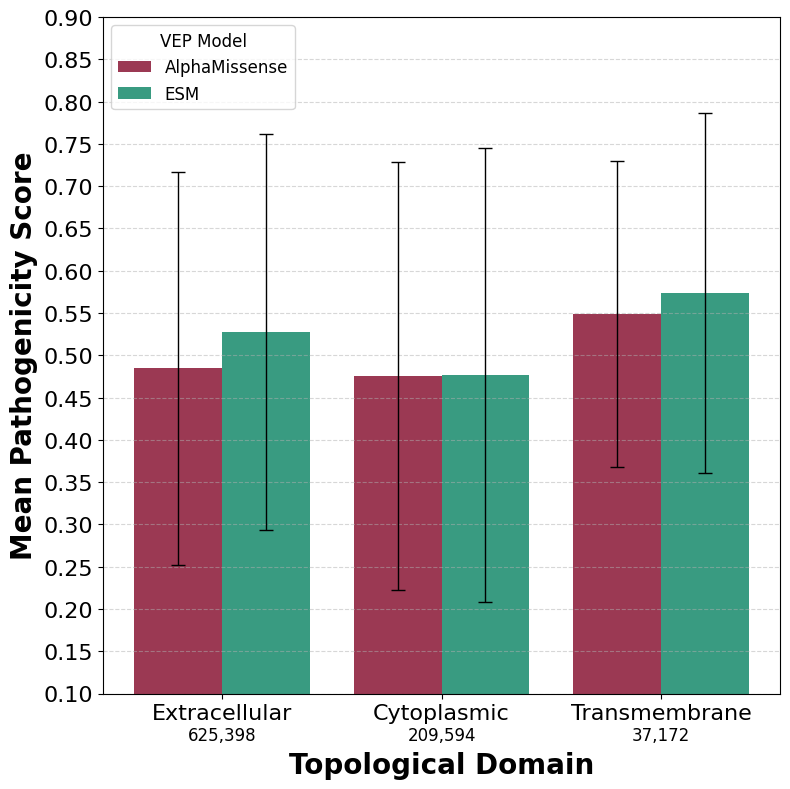

In [139]:
csv_multispan = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'multispan_2D_structures.csv')
csv_nout = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'n_out_2D_structures.csv')
csv_human = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'human_2D_structures.csv')

csv_multispan2 = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'multispan_Topology_structures.csv')
csv_nout2 = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'n_out_Topology_structures.csv')
csv_human2 = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'human_Topology_structures.csv')


# Melt mean and std
df_mean = csv_nout2.melt(id_vars=['Structure'], value_vars=['AM_mean', 'ESM_mean'],
                         var_name='Type', value_name='Mean_Rank_Score')
df_std = csv_nout2.melt(id_vars=['Structure'], value_vars=['AM_std', 'ESM_std'],
                        var_name='Type', value_name='STD')

# Clean 'Type' labels
df_mean['Type'] = df_mean['Type'].str.replace('_mean', '')
df_std['Type'] = df_std['Type'].str.replace('_std', '')

# Merge mean and std
long_df = pd.merge(df_mean, df_std, on=['Structure', 'Type'])

# Plot
plt.figure(figsize=(8, 8))
barplot = sns.barplot(data=long_df, x='Structure', y='Mean_Rank_Score', hue='Type',
                      palette=[COLORS_MODELS['AM'], COLORS_MODELS['ESM']],
                      errorbar=None)

# Manually add error bars
for bar, (_, row) in zip(barplot.patches, long_df.iterrows()):
    height = bar.get_height()
    std = row['STD']
    x = bar.get_x() + bar.get_width() / 2
    plt.errorbar(x, height, yerr=std, fmt='none', c='black', capsize=5, linewidth=1)

# Add count labels (once per structure)
grouped_counts = csv_nout2.set_index('Structure')['count'].to_dict()
for idx, tick in enumerate(barplot.get_xticks()):
    structure = barplot.get_xticklabels()[idx].get_text()
    count = grouped_counts.get(structure, "")
    plt.text(tick, 0.04, f'{count:,}', ha='center', va='bottom', fontsize=12)

# Formatting
plt.ylim(0.1, 0.9)
plt.yticks(np.arange(0.1, 0.92, 0.05), fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel('Topological Domain', labelpad=20, fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.ylabel('Mean Pathogenicity Score', fontsize=20, fontweight='bold')
#plt.title('Mean Rank Scores for Human Proteome Structures')
plt.legend(title='VEP Model', loc='upper left', labels=['AlphaMissense', 'ESM'], fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.savefig(IMAGES_DIR / "1.5.Clustering_2D" / "Topology_Rankscore_nout_structure.png", dpi=300)
plt.show()

In [128]:
from scipy.stats import ttest_ind_from_stats

# Provided summary statistics
mean_AM = 0.3975687998255805
std_AM = 0.23364254258191114
n_AM = 3733524

mean_ESM = 0.3835438919369473
std_ESM = 0.24002080007608
n_ESM = 3733524

# Perform Welch’s t-test
t_stat, p_value = ttest_ind_from_stats(mean1=mean_AM, std1=std_AM, nobs1=n_AM,
                                       mean2=mean_ESM, std2=std_ESM, nobs2=n_ESM,
                                       equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")


T-statistic: 80.9031
P-value: 0.0000e+00


In [107]:
import numpy as np

# Pooled standard deviation (unbiased, unequal n)
pooled_sd = np.sqrt((std_AM**2 + std_ESM**2) / 2)
cohens_d = (mean_AM - mean_ESM) / pooled_sd

print(f"Cohen's d: {cohens_d:.4f}")


Cohen's d: 0.0592


### 5. Computing the secondary structures in the clusters of difference

In [215]:
# Load cluster annotation data
# 1. Human Proteome IDs
human_proteome_ids = pd.read_csv(PROTEIN_IDS_CSV) #"Protein_ID"
# 2. n_out Proteome
nout_proteome_ids = pd.read_csv(PROCESSED_DIR / "Human_N_Out_Proteome.csv", usecols=["entry"]) #"entry"
# 3. Multispan Proteome
multispan_proteome_ids = pd.read_csv(RAW_DIR / "multipass.tsv", sep="\t") #"Entry"



count_errors = 0 
# Final results across all proteins
final_aggregate = {
    "residues_n": 0,
    "am_sum": 0.0,
    "esm_sum": 0.0,
    "rASA_sum": 0.0,
    "structure_counts_AM": Counter(),
    "structure_counts_ESM": Counter(),
    "all_am_scores": [],
    "all_esm_scores": []
}

for protein_id in tqdm(multispan_proteome_ids["Entry"], desc="Processing proteins"):
    # Load Rank Score statistics for a protein
    try:
        cluster_df = pd.read_csv(get_paths()["clusters_path"] / f"{protein_id}_clusters.csv")
        protein_statistics = pd.read_csv(get_paths_protein(protein_id)["dssp_protein_path"])   
    except:
        count_errors += 1
        print(f"{protein_id}. Skipping: {count_errors} errors encountered.")
        continue

    # Per protein aggregation
    protein_aggregate = {
        "residues_n": 0,
        "am_sum": 0.0,
        "esm_sum": 0.0,
        "rASA_sum": 0.0,
        "structure_counts_AM": Counter(),
        "structure_counts_ESM": Counter(),
    }

    # Plot each cluster region as a rectangle
    for _, row in cluster_df.iterrows():
        try:
            start, end = map(int, row['range'].split('-'))
        
        except:
            continue
        
        # Filter rows where 'residue_position' is between start and end
        filtered_rows = protein_statistics[
            (protein_statistics['residue_position'] >= start) & 
            (protein_statistics['residue_position'] <= end)
        ]
        if filtered_rows.empty:
            continue

        residues_n = len(filtered_rows)
        am_scores = filtered_rows['AM_mean'].values
        esm_scores = filtered_rows['ESM_mean'].values
        rASA_scores = filtered_rows['rASA'].values
        
        if row['more pathogenic'] == "AlphaMissense":   # excluding ESM clusters 
            structure_counts_AM = filtered_rows['2D_Structures'].value_counts()
            structure_counts_ESM = 0
        else:
            structure_counts_ESM = filtered_rows['2D_Structures'].value_counts()
            structure_counts_AM = 0
        

        # Update per-protein aggregate
        protein_aggregate["residues_n"] += residues_n
        protein_aggregate["am_sum"] += am_scores.mean() * residues_n
        protein_aggregate["esm_sum"] += esm_scores.mean() * residues_n
        protein_aggregate["rASA_sum"] += rASA_scores.mean() * residues_n

        if row['more pathogenic'] == "AlphaMissense": 
            protein_aggregate["structure_counts_AM"] += structure_counts_AM
        else:
            protein_aggregate["structure_counts_ESM"] += structure_counts_ESM

        # Store for std dev
        final_aggregate["all_am_scores"].extend(am_scores)
        final_aggregate["all_esm_scores"].extend(esm_scores)

    # Update final aggregate
    final_aggregate["residues_n"] += protein_aggregate["residues_n"]
    final_aggregate["am_sum"] += protein_aggregate["am_sum"]
    final_aggregate["esm_sum"] += protein_aggregate["esm_sum"]
    final_aggregate["rASA_sum"] += protein_aggregate["rASA_sum"]


    if row['more pathogenic'] == "AlphaMissense": 
        final_aggregate["structure_counts_AM"] += protein_aggregate["structure_counts_AM"]
    else:
        final_aggregate["structure_counts_ESM"] += protein_aggregate["structure_counts_ESM"]

    



# Compute final means and standard deviations
final_result = {
    "residues_n": final_aggregate["residues_n"],
    "AM_mean": np.mean(final_aggregate["all_am_scores"]) if final_aggregate["all_am_scores"] else None,
    "AM_std": np.std(final_aggregate["all_am_scores"]) if final_aggregate["all_am_scores"] else None,
    "ESM_mean": np.mean(final_aggregate["all_esm_scores"]) if final_aggregate["all_esm_scores"] else None,
    "ESM_std": np.std(final_aggregate["all_esm_scores"]) if final_aggregate["all_esm_scores"] else None,
    "rASA_mean": final_aggregate["rASA_sum"] / final_aggregate["residues_n"] if final_aggregate["residues_n"] else None,
    "structure_counts_AM": dict(final_aggregate["structure_counts_AM"]),
    "structure_counts_ESM": dict(final_aggregate["structure_counts_ESM"]),
}


print(final_result)

Processing proteins:   0%|          | 0/2834 [00:00<?, ?it/s]

A0AV02. Skipping: 1 errors encountered.
A0FGR8. Skipping: 2 errors encountered.
A1A5B4. Skipping: 3 errors encountered.
A1L3X0. Skipping: 4 errors encountered.
F5H094. Skipping: 5 errors encountered.
O00124. Skipping: 6 errors encountered.
O00155. Skipping: 7 errors encountered.
O00501. Skipping: 8 errors encountered.
O00574. Skipping: 9 errors encountered.
O00590. Skipping: 10 errors encountered.
O14493. Skipping: 11 errors encountered.
O14520. Skipping: 12 errors encountered.
O14684. Skipping: 13 errors encountered.
O14735. Skipping: 14 errors encountered.
O14804. Skipping: 15 errors encountered.
O14843. Skipping: 16 errors encountered.
O14880. Skipping: 17 errors encountered.
O15121. Skipping: 18 errors encountered.
O15126. Skipping: 19 errors encountered.
O15244. Skipping: 20 errors encountered.
O15258. Skipping: 21 errors encountered.
O15431. Skipping: 22 errors encountered.
O15432. Skipping: 23 errors encountered.
O15529. Skipping: 24 errors encountered.
O15551. Skipping: 25 erro

In [216]:
PROTEOME =  "multispan"  # or "human", "n_out"

overall_structure_freq = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / f"{PROTEOME}_2D_structures.csv")

# Final structure counts
structure_counts_AM = final_result["structure_counts_AM"]
structure_counts_ESM = final_result["structure_counts_ESM"]

total_cluster_residues = final_result["residues_n"]

# Mapping from DSSP code to full name
structure_codes = {
    "H": "Alpha helix",
    "B": "Beta bridge",
    "E": "Strand",
    "G": "Helix-3",
    "I": "Helix-5",
    "T": "Turn",
    "S": "Bend",
    "P": "κ‐helix",
    "-": "Disorded"
}

# Reverse mapping to easily go from full name to DSSP code
reverse_structure_codes = {v: k for k, v in structure_codes.items()}

# Add two new columns with default zero
overall_structure_freq[f"{PROTEOME}_diff_count_AM"] = 0
overall_structure_freq[f"{PROTEOME}_diff_count_ESM"] = 0

overall_structure_freq[f"{PROTEOME}_diff_percentage_AM"] = 0.0
overall_structure_freq[f"{PROTEOME}_diff_percentage_ESM"] = 0.0


# Fill in counts and raw percentages
for idx, row in overall_structure_freq.iterrows():
    struct_name = row["Structure"]
    dssp_code = reverse_structure_codes.get(struct_name)

    if dssp_code in structure_counts_AM:
        count = structure_counts_AM[dssp_code]
        percentage = count / sum(structure_counts_AM.values()) * 100  # Use sum of all values in structure_counts

        overall_structure_freq.at[idx, f"{PROTEOME}_diff_count_AM"] = count
        overall_structure_freq.at[idx, f"{PROTEOME}_diff_percentage_AM"] = percentage

    if dssp_code in structure_counts_ESM:
        count = structure_counts_ESM[dssp_code]
        percentage = count / sum(structure_counts_ESM.values()) * 100  # Use sum of all values in structure_counts

        overall_structure_freq.at[idx, f"{PROTEOME}_diff_count_ESM"] = count
        overall_structure_freq.at[idx, f"{PROTEOME}_diff_percentage_ESM"] = percentage




# Normalize by background frequency (adjusting for representation bias)
# Formula: (actual_count / expected_count_based_on_background_freq)

total_proteome_residues = overall_structure_freq["count"].sum()



In [217]:

overall_structure_freq.to_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / f"{PROTEOME}_proteome_structures_with_diff_cluster.csv", index=False)
overall_structure_freq.head(10)

,Structure,AM_mean,AM_std,ESM_mean,ESM_std,count,percentage,multispan_diff_count_AM,multispan_diff_count_ESM,multispan_diff_percentage_AM,multispan_diff_percentage_ESM
0,Alpha helix,0.564287,0.219378,0.593720,0.225947,730498,52.965534,51265,80154,44.560824,58.406809
1,Disorded,0.378367,0.241817,0.383944,0.241361,298133,21.616450,35228,20592,30.621061,15.005028
2,Turn,0.489490,0.249463,0.529094,0.248634,97765,7.088555,7984,10576,6.939893,7.706545
3,Strand,0.604950,0.232034,0.608774,0.232997,85287,6.183825,6778,7342,5.891608,5.349986
4,Bend,0.488103,0.255649,0.516105,0.253958,71530,5.186359,6157,7696,5.351819,5.607940
5,Helix-3,0.508645,0.254262,0.543354,0.253485,37351,2.708174,3040,4723,2.642444,3.441567
6,κ‐helix,0.406718,0.260527,0.442798,0.248394,33560,2.433303,3232,3448,2.809335,2.512497
7,Helix-5,0.617641,0.202091,0.655650,0.201027,18139,1.315187,898,1912,0.780564,1.393241
8,Beta bridge,0.589149,0.240394,0.606506,0.231850,6932,0.502612,463,791,0.402451,0.576388


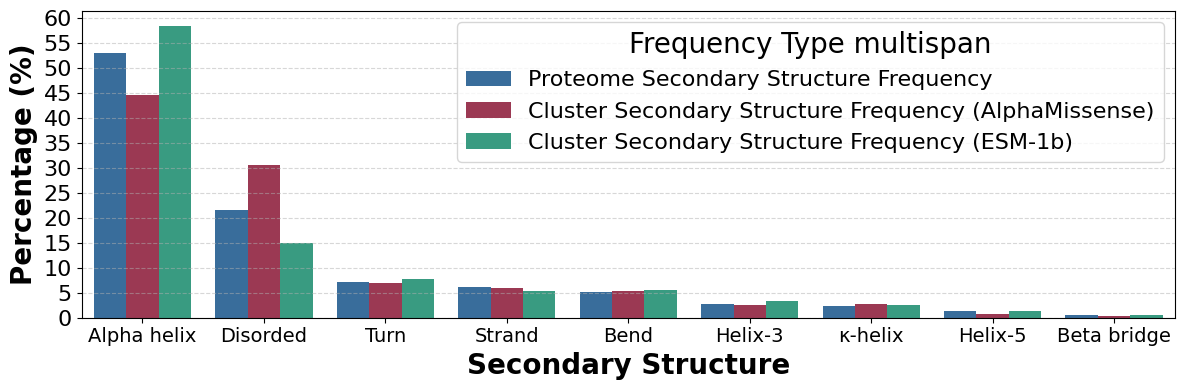

In [232]:
PROTEOME = "multispan"  # or "n_out", "multispan", "human"
overall_structure_freq = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / f"{PROTEOME}_proteome_structures_with_diff_cluster.csv")
# Sort by cleaned percentage for better readability
df = overall_structure_freq.sort_values("count", ascending=False)

# Prepare Data for Plotting
plot_df = pd.melt(
    df,
    id_vars="Structure",
    value_vars=[
        "percentage", 
        f"{PROTEOME}_diff_percentage_AM",
        f"{PROTEOME}_diff_percentage_ESM"
    ],
    var_name="Frequency_Type",
    value_name="Percentage"
)

plot_df.head(10)

# Rename for clarity
plot_df["Frequency_Type"] = plot_df["Frequency_Type"].replace({
    "percentage": "Proteome Secondary Structure Frequency",
    f"{PROTEOME}_diff_percentage_AM": "Cluster Secondary Structure Frequency (AlphaMissense)",
    f"{PROTEOME}_diff_percentage_ESM": "Cluster Secondary Structure Frequency (ESM-1b)"
})



# Define custom colors for each hue category
custom_palette = {"Proteome Secondary Structure Frequency": "#296EAB", 
                  "Cluster Secondary Structure Frequency (AlphaMissense)": COLORS_MODELS['AM'],
                  "Cluster Secondary Structure Frequency (ESM-1b)" : COLORS_MODELS['ESM']
                  }

# Create the barplot with custom colors



# Plot
plt.figure(figsize=(12, 4))
sns.barplot(data=plot_df, x="Structure", y="Percentage", hue="Frequency_Type", palette=custom_palette)
plt.xticks(rotation=0, fontsize=14)
#plt.title("Structure Frequencies: Proteome vs. Raw vs. Cleaned Cluster")
plt.ylabel("Percentage (%)", fontsize=20, fontweight='bold')
plt.yticks(np.arange(0, 65, 5), fontsize=16)
plt.xlabel("Secondary Structure", fontsize=20, fontweight='bold')
plt.legend(title=f"Frequency Type {PROTEOME}", fontsize=16, title_fontsize=20, loc='upper right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig(IMAGES_DIR / "1.5.Clustering_2D" / f"{PROTEOME}_diff_structure_frequencies.png", dpi=300)
plt.show()

In [208]:
plot_df.head(20)

,Structure,Frequency_Type,Percentage
0,Disorded,Proteome Secondary Structure Frequency,34.757919
1,Alpha helix,Proteome Secondary Structure Frequency,31.759066
2,Strand,Proteome Secondary Structure Frequency,11.926307
3,Turn,Proteome Secondary Structure Frequency,8.171135
4,Bend,Proteome Secondary Structure Frequency,6.041453
5,κ‐helix,Proteome Secondary Structure Frequency,3.812026
6,Helix-3,Proteome Secondary Structure Frequency,2.537894
7,Beta bridge,Proteome Secondary Structure Frequency,0.580477
8,Helix-5,Proteome Secondary Structure Frequency,0.413722
9,Disorded,Cluster Secondary Structure Frequency (AlphaMi...,41.238662


In [209]:
overall_structure_freq.head(10)

,Structure,AM_mean,AM_std,ESM_mean,ESM_std,count,percentage,human_diff_count_AM,human_diff_count_ESM,human_diff_percentage_AM,human_diff_percentage_ESM
0,Disorded,0.397569,0.233643,0.383544,0.240021,3733524,34.757919,529890,241126,41.238662,27.866624
1,Alpha helix,0.566651,0.226315,0.568885,0.241446,3411402,31.759066,394406,282711,30.694627,32.672550
2,Strand,0.622874,0.222792,0.629469,0.223651,1281065,11.926307,100533,118170,7.823976,13.656756
3,Turn,0.508614,0.243727,0.536986,0.244828,877703,8.171135,91958,83106,7.156627,9.604454
4,Bend,0.517844,0.251648,0.527346,0.255640,648943,6.041453,74032,61043,5.761537,7.054662
5,κ‐helix,0.436771,0.250694,0.459619,0.248220,409469,3.812026,52036,43033,4.049699,4.973269
6,Helix-3,0.523241,0.249654,0.532861,0.255329,272608,2.537894,33031,25851,2.570636,2.987567
7,Beta bridge,0.603911,0.249805,0.610322,0.245270,62352,0.580477,5220,6106,0.406246,0.705663
8,Helix-5,0.624468,0.216573,0.639841,0.221377,44440,0.413722,3829,4140,0.297992,0.478455
